# Input
> Library: import the libraries were used on this project

> Function: make utility functions for maintain and handing similar and frequent problems

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
URL = "https://raw.githubusercontent.com/SeekkerChu/UCI_Marketing/refs/heads/main/Data_set/bank_additional.csv.text"

Two functions:
> `make_ditribution` for ploting, given a dataframe or list, this function can auto select how many columns and rows in one figure

> `detect_outliers` for detecting outliers based on IQR method

In [ ]:
def make_distribution(data, cols=5, figsize=(16, 10), title=None):
    """
    Create a function to make numerical distribution(LLMs help)

    Parameters:
    - data: DataFrame of categorical columns OR list of Series
    - cols: number of subplot columns
    - figsize: figure size
    - title: optional main title
    """

    if hasattr(data, "columns"):
        data_series = [data[col] for col in data.columns]
        col_names = list(data.columns)
    else:
        data_series = data
        col_names = [s.name if hasattr(s, "name") else f"col_{i}" for i, s in enumerate(data)]

    n = len(data_series)
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for i, series in enumerate(data_series):
        ax = axes[i]
        sns.histplot(series, kde=True, ax=ax)
        ax.set_title(col_names[i])

    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    if title:
        fig.suptitle(title, fontsize=16, y=1.02)

    plt.tight_layout()
    plt.show()

In [ ]:
def detect_outliers(df, cols, precent_q1 = 0.25, precent_q3 = 0.75):
  """
  function for detect the outliers

  Parameters:
    - df: DataFrame
    - cols: columns
    - precent_q1: q1
    - precent_q3: q3
  """
  outlier_info = {}

  if precent_q1 >=1 or precent_q1 <=0:
    raise ValueError("please set q1 0 to 1")
  if precent_q3 >=1 or precent_q3 <=0:
    raise ValueError("please set q3 0 to 1")

  for col in cols:
      Q1 = df[col].quantile(precent_q1)
      Q3 = df[col].quantile(precent_q3)
      IQR = Q3 - Q1

      lower = Q1 - 1.5 * IQR
      upper = Q3 + 1.5 * IQR

      mask = (df[col] < lower) | (df[col] > upper)
      count = mask.sum()
      percentage = count / len(df) * 100

      outlier_info[col] = {
          "lower": lower,
          "upper": upper,
          "count": count,
          "percentage": round(percentage, 2)
        }

  return pd.DataFrame(outlier_info).T

# Data Cleaning:

> Read csv file separate by ";", Copy row data into df_clean, make sure row data haven't changed

> Describe numerical statistics values by `.describe()`

> Find out NA values, but the dataset not includes the NA but "unknown" values. For different percentage contents, choose impute, remove or keep.

> Detect outliers for each numerical columns, and based on finance concepts to decide remove the outliers or impute.


In [ ]:
df = pd.read_csv(URL, sep=";")
df_clean = df.copy()

Total features:

In [ ]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

Look at the describe, thinking the min and max values whether are reasonable. It shows pdays have huge difference

In [ ]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000
mean,40.113620,256.788055,2.537266,960.422190,0.190337,0.084972,93.579704,-40.499102,3.621356,5166.481695
std,10.313362,254.703736,2.568159,191.922786,0.541788,1.563114,0.579349,4.594578,1.733591,73.667904
min,18.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.635000,4963.600000
25%,32.000000,103.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.334000,5099.100000
50%,38.000000,181.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,317.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,88.000000,3643.000000,35.000000,999.000000,6.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Look at how many unknown values in the dataset

In [ ]:
unknown_per_column = df.eq("unknown").sum()
print(unknown_per_column)

age                 0
job                39
marital            11
education         167
default           803
housing           105
loan              105
contact             0
month               0
day_of_week         0
duration            0
campaign            0
pdays               0
previous            0
poutcome            0
emp.var.rate        0
cons.price.idx      0
cons.conf.idx       0
euribor3m           0
nr.employed         0
y                   0
dtype: int64


Since 'job','marital','education','housing','loan','contact','month','day_of_week','poutcome' features only showed 11/4119(0.26%) to 167/4119(4.05%), so I decided to impute the most common data to replace the "unknown" values.

In [ ]:
categorical_cols = ['job','marital','education','housing','loan','contact','month','day_of_week','poutcome']
df_clean[categorical_cols] = df_clean[categorical_cols].replace('unknown', np.nan)

Be

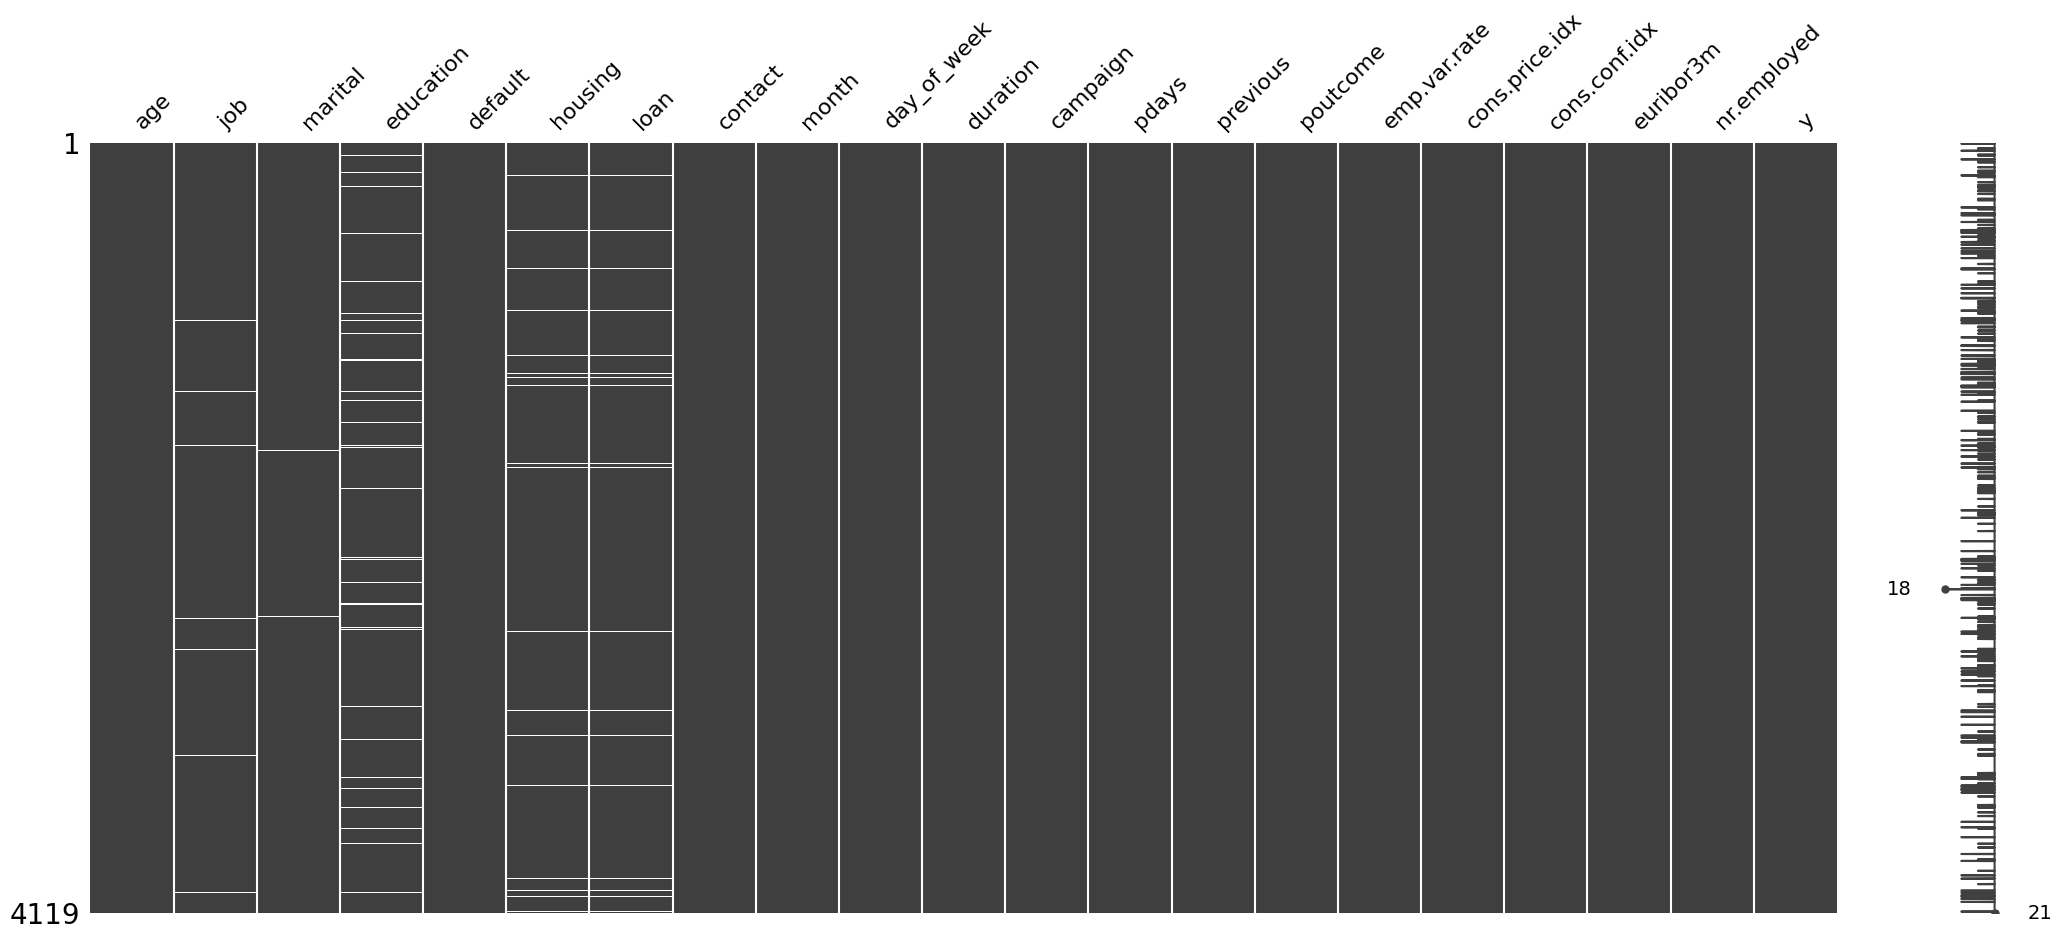

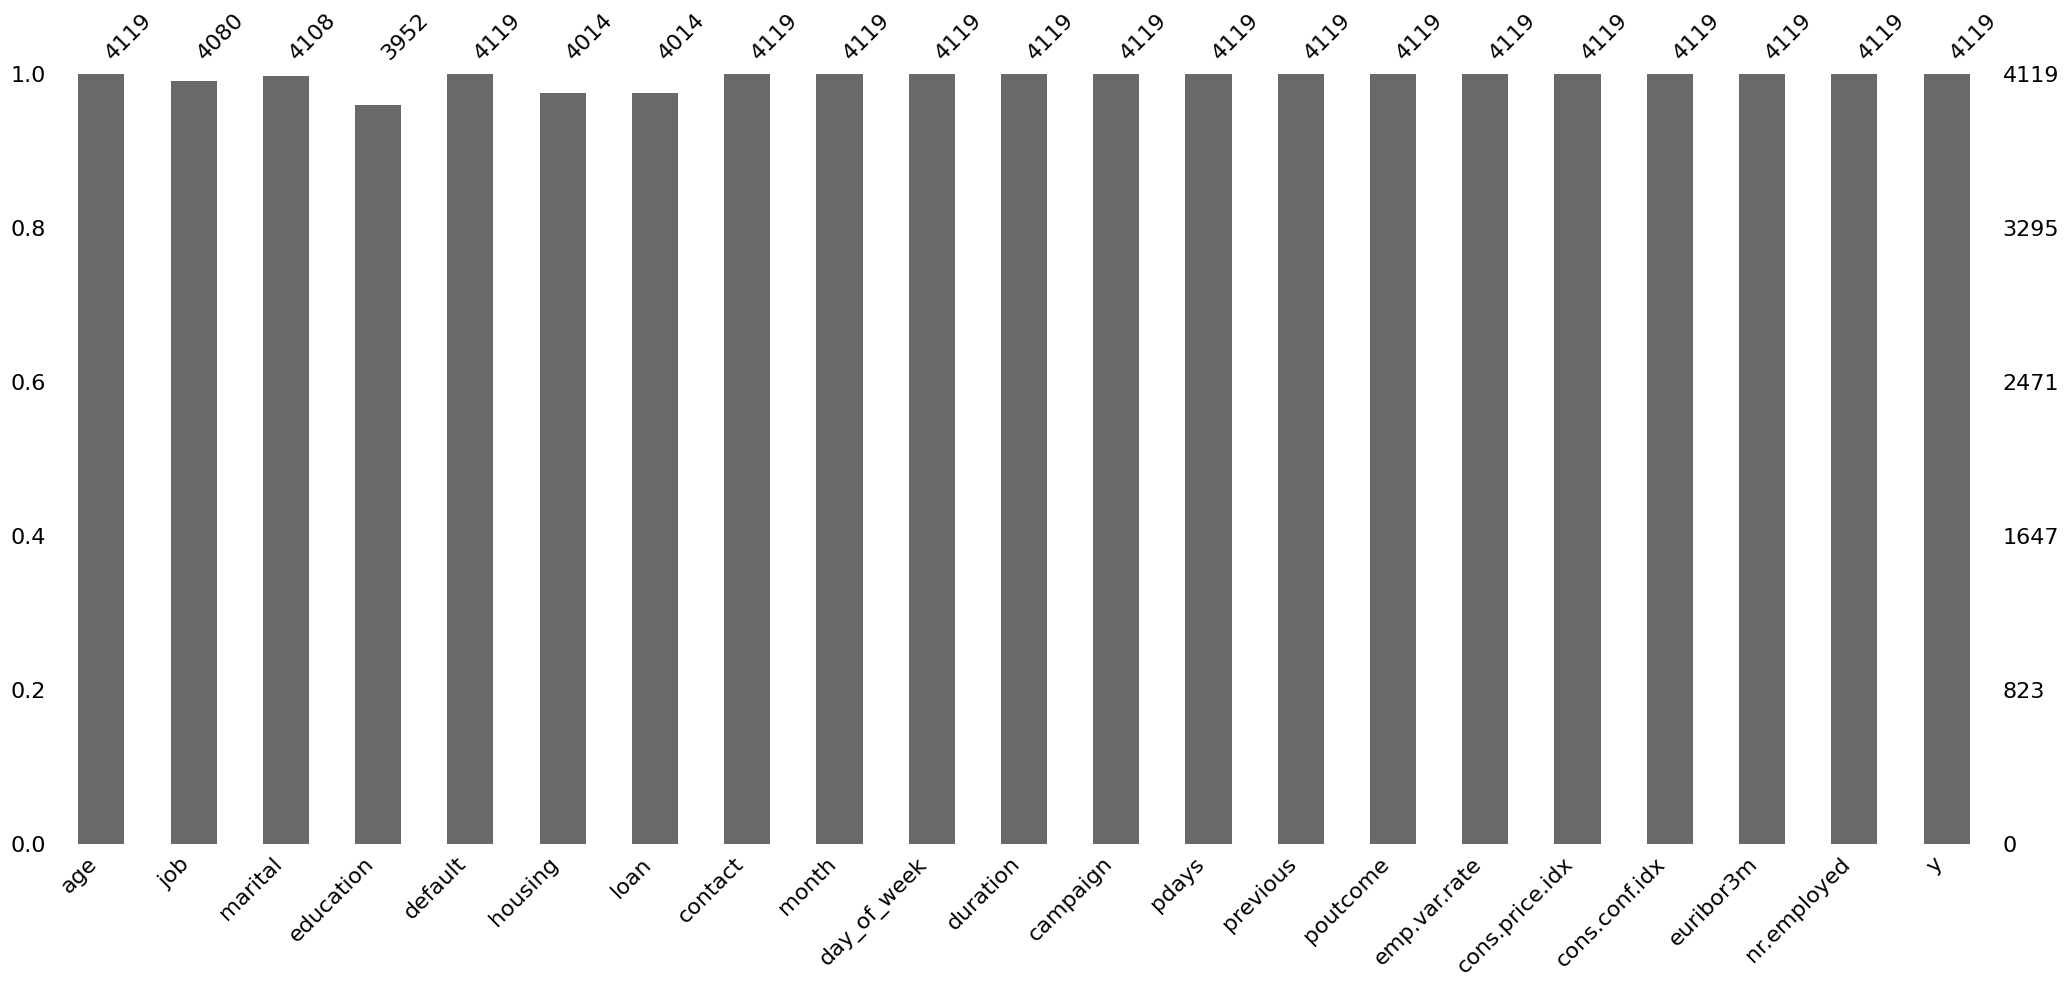

In [ ]:
msno.matrix(df_clean)
plt.show()

msno.bar(df_clean)
plt.show()

In [ ]:
cols_small_missing = ["job", "marital", "housing", "education", "loan"]
for col in cols_small_missing:
    df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])


In [ ]:
unknown_per_column = df_clean.eq("unknown").sum()
print(unknown_per_column)

age                 0
job                 0
marital             0
education           0
default           803
housing             0
loan                0
contact             0
month               0
day_of_week         0
duration            0
campaign            0
pdays               0
previous            0
poutcome            0
emp.var.rate        0
cons.price.idx      0
cons.conf.idx       0
euribor3m           0
nr.employed         0
y                   0
dtype: int64


In [ ]:
df_clean["y"] = df_clean["y"].map({"yes": 1, "no": 0})

In [ ]:
numeric_cols = [
    'age', 'duration', 'campaign', 'pdays', 'previous',
    'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
    'euribor3m', 'nr.employed'
]

categorical_cols = ['job','marital','education','default','housing','loan',
                    'contact','month','day_of_week','poutcome']

In [ ]:
outliers_table = detect_outliers(df_clean, numeric_cols,precent_q1=0.05, precent_q3=0.95)
outliers_table

,lower,upper,count,percentage
age,-22.000,106.0000,0.0,0.00
duration,-1022.800,1798.0000,10.0,0.24
campaign,-8.000,16.0000,26.0,0.63
pdays,999.000,999.0000,160.0,3.88
previous,-1.500,2.5000,43.0,1.04
emp.var.rate,-9.350,7.8500,0.0,0.00
cons.price.idx,90.085,97.0930,0.0,0.00
cons.conf.idx,-67.350,-13.3500,0.0,0.00
euribor3m,-5.428,11.2024,0.0,0.00
nr.employed,4679.600,5557.2000,0.0,0.00


EDA

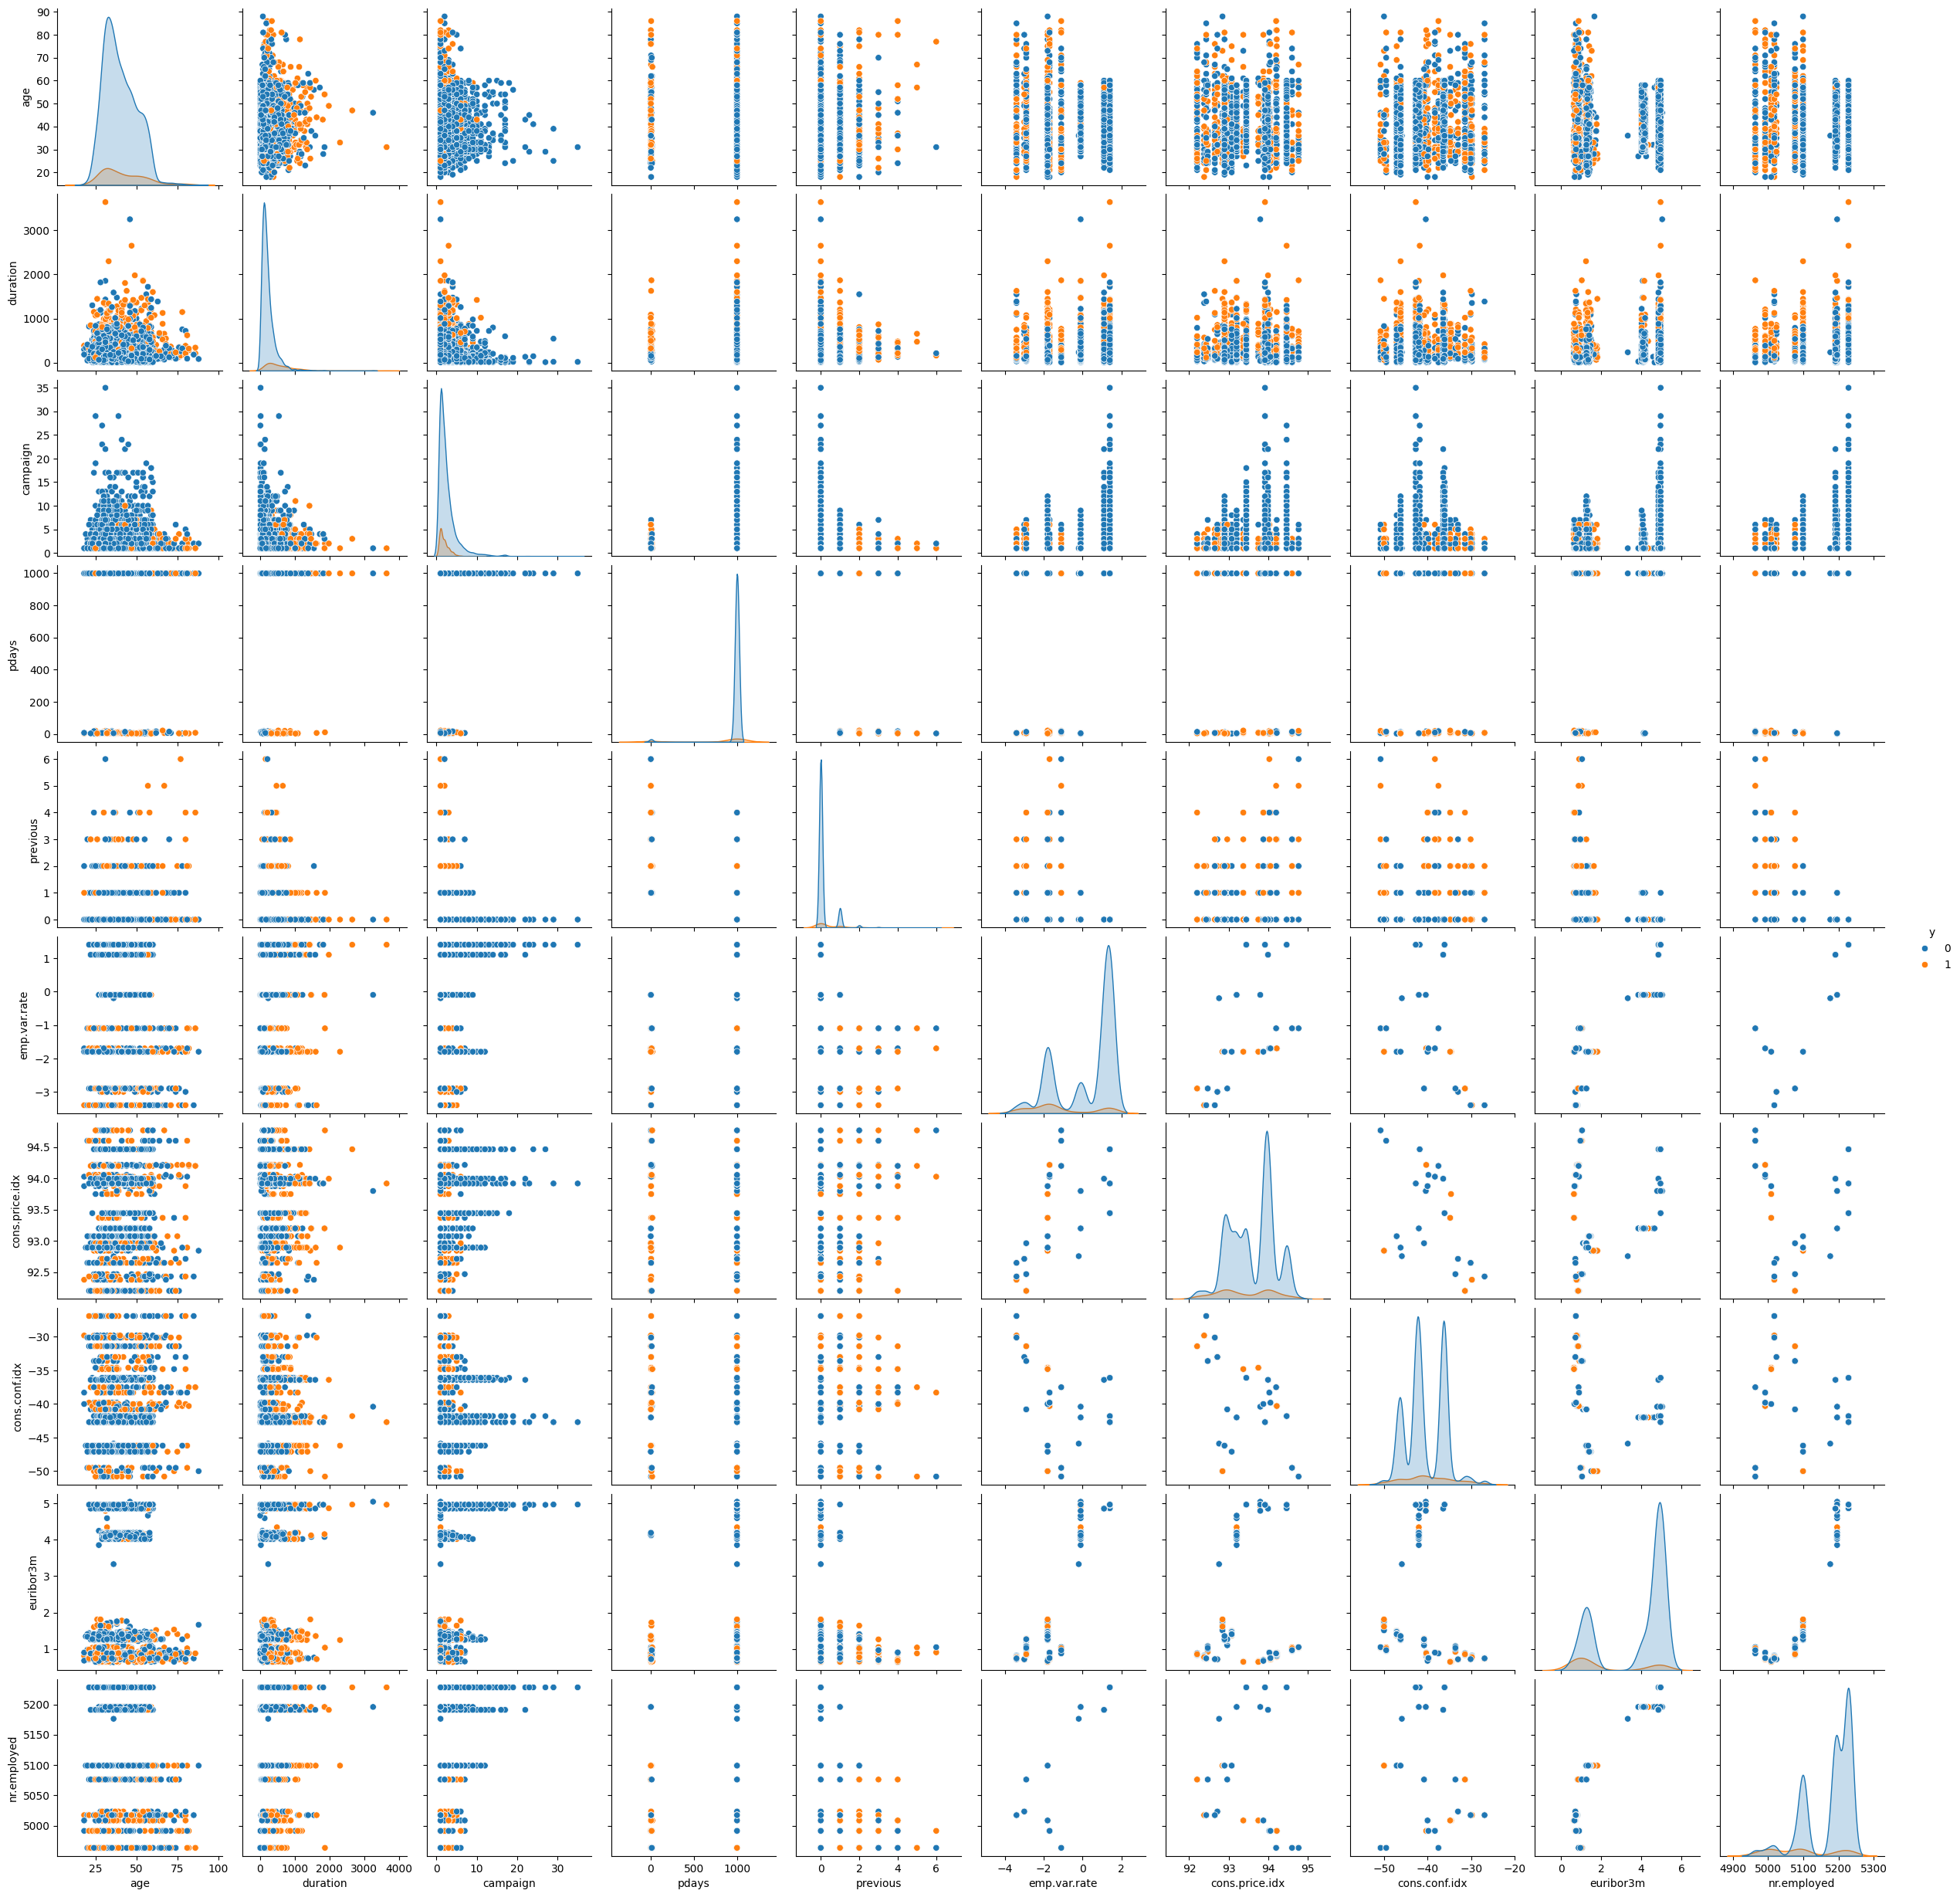

In [ ]:
sns.pairplot(df_clean, hue='y')

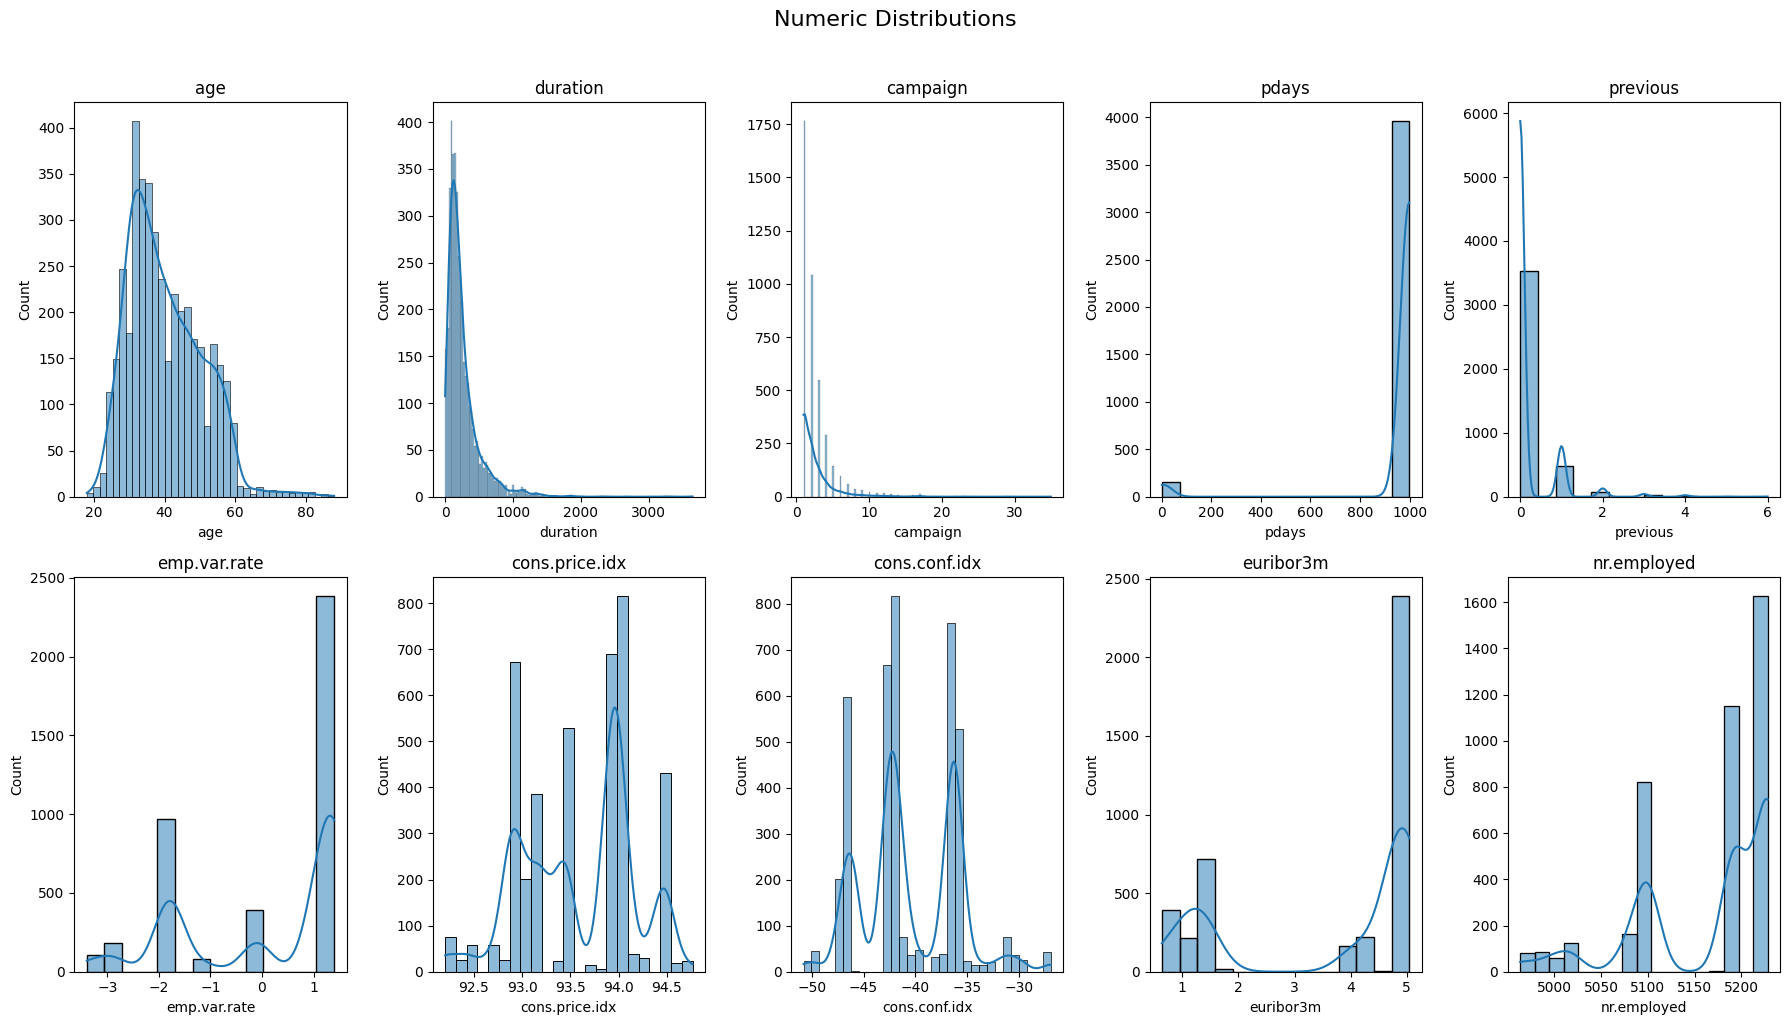

In [ ]:
make_distribution(df_clean[numeric_cols], cols=5, figsize=(18,10), title="Numeric Distributions")

After seeing this, I think change pdays to 0 and 1 will be better, and the campaingn should not has the -2

In [ ]:
df_clean.loc[df_clean['campaign'] < 1, 'campaign'] = 1

df_clean['pdays'] = np.where(df_clean['pdays'] == 999, 1, 0)

I think we don't have to put durtion into the model, since it is future informations, and the pariplot shows they have a strong relationship, if put it into the model, the model may base on this feature to predict the value.

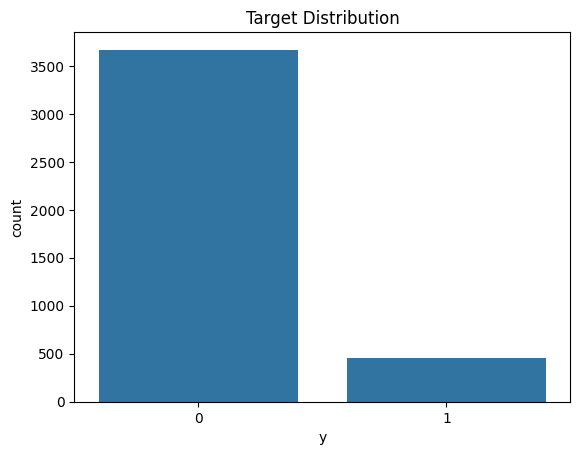

In [ ]:
sns.countplot(data=df_clean, x='y')
plt.title("Target Distribution")
plt.show()

Split X and Y

In [ ]:
X = df_clean.drop(['y','duration'], axis=1)
Y = df_clean['y']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

Build a preprocessor for changing
>Handle categoricla variables(Encoding)

>Normalize and Standarlize numerical

Pipeline for maintaining

Since y has 87.5% no and 12.5% yes:
>control the weight on model setting

>Change threshold.

In [ ]:
numeric_cols = [
    'age', 'campaign', 'pdays', 'previous',
    'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
    'euribor3m', 'nr.employed'
]

categorical_cols = [
    'job','marital','education','default','housing','loan',
                    'contact','month','day_of_week','poutcome'
]

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('category', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('numerical', StandardScaler(), numeric_cols)
    ]
)

model_log = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

model_log.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('category',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome']),
                                                 ('numerical', StandardScaler(),
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [ ]:
# Get the preprocessing step
preprocess = model_log.named_steps['preprocess']

# Get all transformed feature names
feature_names = []

for name, transformer, cols in preprocess.transformers_:
    if name == 'category':
        # OneHotEncoder
        ohe = transformer
        ohe_feature_names = list(ohe.get_feature_names_out(cols))
        feature_names.extend(ohe_feature_names)
    elif name == 'numerical':
        # Numerical features keep their original names
        feature_names.extend(cols)

log_reg = model_log.named_steps['clf']

coefficients = log_reg.coef_[0]   # for binary classification
intercept = log_reg.intercept_[0]

coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
}).sort_values(by='coefficient', ascending=False)

coef_df

,feature,coefficient
35,month_mar,1.283004
32,month_dec,0.584793
53,cons.price.idx,0.582769
55,euribor3m,0.477899
47,poutcome_success,0.359846
28,contact_cellular,0.305033
0,job_admin.,0.273923
10,job_unemployed,0.248399
9,job_technician,0.223460
13,marital_single,0.211193


In [ ]:
y_pred = model_log.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
cm = confusion_matrix(y_pred, y_test)

print(f"Accuracy: {accuracy}")
print(f"confusion matrix:")
print(cm)

Accuracy: 0.8288834951456311
confusion matrix:
[[631  38]
 [103  52]]


Seems like the TP is low, so its recall is low, but the main goal is to know the client will accept fixed deposits, so recall and precision should be high

Due to the unbalanced distribution, maybe change the threshold can make a better result. Based on each loop.

In [ ]:
y_val_proba = model_log.predict_proba(X_test)[:,1]
thresholds = np.arange(0.0, 1.01, 0.01)

threshold = 0
f1 = 0

best_f1 = 0

for t in thresholds:
    y_val_pred = (y_val_proba >= t).astype(int)
    f1 = f1_score(y_test, y_val_pred)
    if f1 > best_f1:
        best_f1 = f1
        threshold = t

print("Best threshold (max F1):", threshold)

Best threshold (max F1): 0.66


In [ ]:
y_test_proba = model_log.predict_proba(X_test)[:,1]
y_test_pred = (y_test_proba >= threshold).astype(int)

cm = confusion_matrix(y_test, y_test_pred)
print("Test Confusion Matrix:\n", cm)
print("Recall:", recall_score(y_test, y_test_pred))
print("Accuracy:", accuracy_score(y_test, y_test_pred))

Test Confusion Matrix:
 [[689  45]
 [ 45  45]]
Recall: 0.5
Accuracy: 0.8907766990291263


K-Means
> use the preprocessor that we already had

In [ ]:
X_prepared = preprocessor.fit_transform(X)

elbow method to select the k

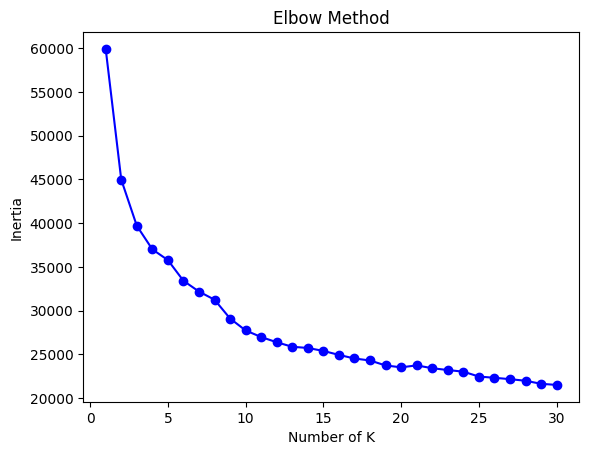

In [ ]:
inertia = []
K = range(1, 31)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_prepared)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of K')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

I think 9 is enough

In [ ]:
k = 9
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_prepared)

pd.crosstab(clusters, Y)

y,0,1
row_0,,
0,378,22
1,365,16
2,777,121
3,62,101
4,587,41
5,478,23
6,132,3
7,698,28
8,191,96


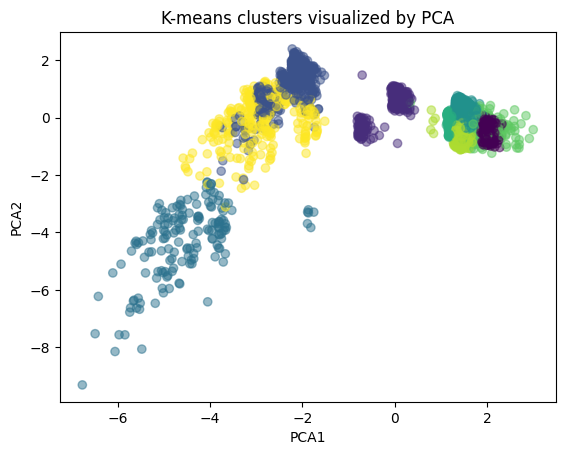

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_prepared)

plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='viridis', alpha=0.5)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('K-means clusters visualized by PCA')
plt.show()

On the PCA plot, we can know the clusters have 3, but the purple and yellow have some megred, and the green maybe have two more clusters.

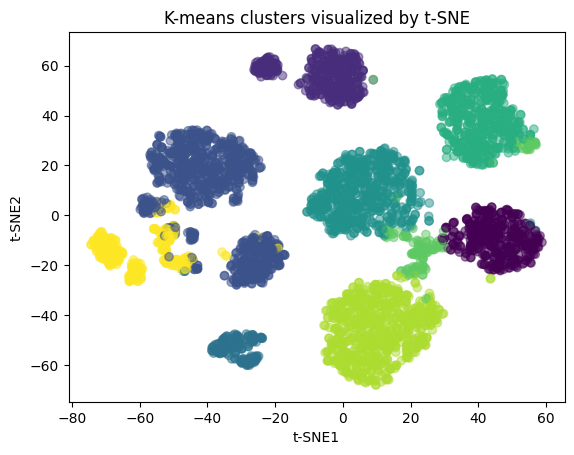

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_prepared)

plt.scatter(X_tsne[:,0], X_tsne[:,1], c=clusters, cmap='viridis', alpha=0.5)
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.title('K-means clusters visualized by t-SNE')
plt.show()

On the t-SNE plot, there are also 3 but the yellow one isn't pop out on this plot, and the grenn seems like 5 clusters.